# Neural Computation Group 30 Final Report 
<a href='https://drive.google.com/drive/folders/1GdNzupgUIY6rwqNopejjxOGdoLf6Oodf?usp=sharing'>Link to Reconstrruction Images</a>


## Introduction  


MRI is one of the most crucial techniques for clinical diagnosis and research. As a non-invasive, repeatable and highly accurate technique, it is essential for modern medical treatment. However, MRI can be difficult and costly. Statistics show that the average price of an MRI scan is $2,611, in the United States [12]. Moreover, it can be uncomfortable for patients who must lie still during the procedure, which can take many minutes or even hours. The long image acquisition time results in a high cost per imaging which has decreased the popularity of MRI.

The information acquired from the MRI scan is in the form of k-space data which is determined by the field-of-view (FOV), the spatial resolution of the image and the Nyquist criterion which determines the minimum sampling rate. <i>Undersampled Acquisition</i> is a method used to reduce the MRI acquisition time, whereby less than the full number of k-space data points are collected. This violates the Nyquist criterion, aliasing artefacts will be seen in the reconstructed images. Aliasing appearance depends on how the samples are taken. Methods have been implemented to reduce the aliasing artefacts, such as; parallel imaging and compressed sensing reconstruction. However, the realisation of parallel imaging requires multiple coils and will not be discussed in this report.


The aim of this report is to present a solution that can produce accurate MRI reconstructions from undersampled k-space data. Hence, would allow MRI scans to be shorter and less costly. The goal is to find a function $f$ that can map the undersampled k-space data to an image $y'$ which is highly similar to the ground truth image $y$, the image reconstructed from fully sampled k-space data. $x_{full}$ denotes the fully sampled k-space data while $x$ denotes the undersampled k-space data. 


<table>
<tr>
<td> <img src="https://i.ibb.co/stXZY4Z/NC-General-Process.png" alt="Drawing" style="width:300px;"/> </td>
<td> <img src="https://i.ibb.co/zNdhGZf/Apply-4fold.png" alt="Drawing" style="width: 300px;"/> </td>
</tr>
<tr>
<td> <center> General Process </center> </td>  
<td> <center> Applying the 4 Fold </center> </td> 
</tr>    
</table>

As shown in Figure 1, the MRI consists of 2 parts; undersampling and reconstruction. The undersampling strategy used in this report is the Cartesian undersampling trajectory. 

First, a random 4-fold/8-fold mask function is generated. Then, the under-sampled k-space data $x$ is simulated by multiplying the mask function and the fully sampled k-space data $x_{full}$. $\mathcal{F}$ represents the Fourier Transformation and $\mathcal{F^{-1}}$ represents the inverse Fourier Transformation. 

In Figure 2, a random 4-fold mask is applied to a fully sampled k-space image to generate the undersampled k-space data. When the Inverse Fourier Transformation is directly applied to the undersampled data ( $f = \mathcal{F}^{-1}$), a blurred image ( $y'$ )is constructed. This report will detail the use of neural networks to learn a reconstruction function $f$ that can produce a sharper, more accurate reconstruction.



## Design

### Network Architecture

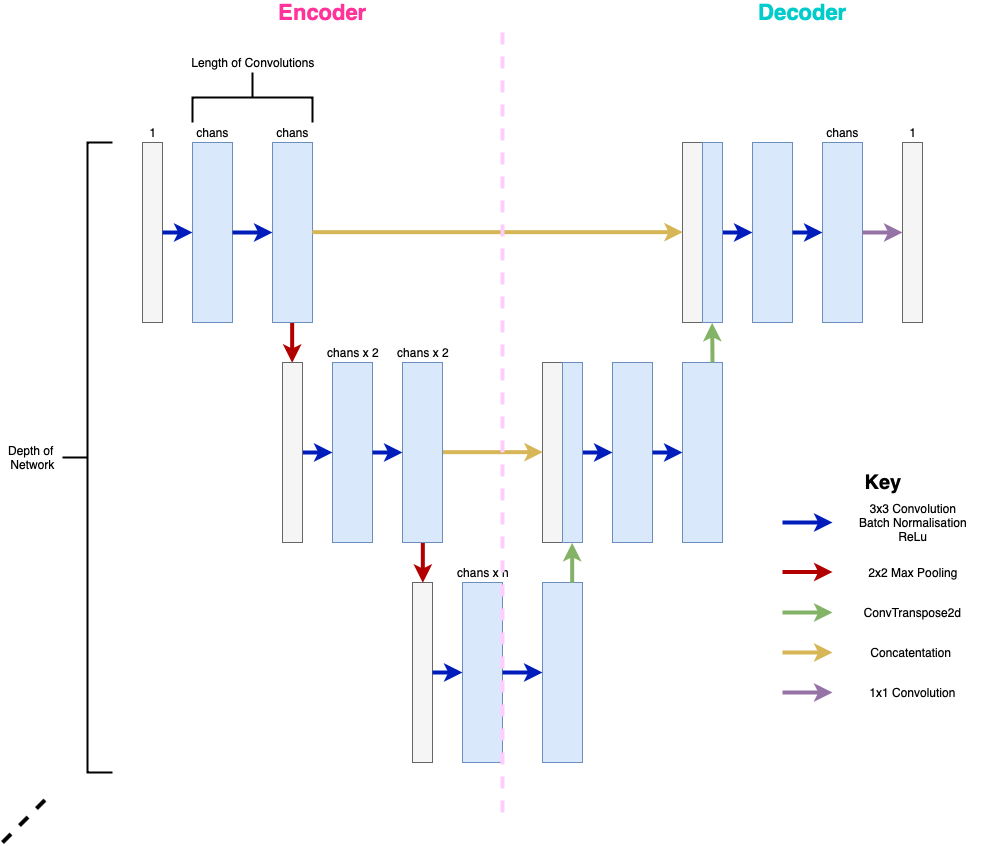

The architecture of the network is U-Net. 
The U-Net is a Fully Convolutional Network that is adapted to yield better segmentation in medical imaging, making it useful for the task of MRI reconstruction from undersampled k-space data. 

The U-Net consists of 3 parts:
<ol>
    <li>Downsampling path</li>
    <li>Bottleneck</li>
    <li>Upsampling path</li>
</ol>
    
The network is symmetric and applies skip connections which are concatenations between layers in the downsampling path and layers in the upsampling path. These provide higher resolution features from the downsampling to global information from the upsampled features in order to better localise and learn representations in subsequent convolutions. 

<b>Downsampling path:</b>
The downsampling path is comprised of n number of convolutional blocks, tied together by 2x2 max pooling. 
Each convolutional block is composed of m lots of 
<ol>
    <li>3x3 Convolution Layer </li>
    <li>Batch normalisation </li>
    <li>Activation function (ReLu) </li>
    </ol>
Where m is specified upon creation of the network and is a hyperparameter. 

Initially, the input image is fed into the network with 1 channel. After it passes through the first convolutional block, the number of channels increases to 32.
The number of feature maps doubles after each pool. The deeper the network, the larger the feature maps. The purpose of this is to reduce the spatial information and increase the feature information. It allows the context of the image to be captured in order to perform image segmentation. During the skip-connections, this contextual information is transferred to the upsampling path. 

The hyperparameter n, determines the depth of the network. It is specified at the time of the network’s creation. During experimentation, the value of n and m were changed and their effect on the network’s performance analysed. 

<b>Bottleneck:</b>
The last layer of the downsampling path acts as a bottleneck. It consists of one convolutional block. 

<b>Upsampling Path:</b>
The expanding side of the network also consists of n convolutional blocks. This time, they are separated by a 2x2 Deconvolution layer (convolution of transpose)  with stride of 2 and kernel size of 2. Moreover, the corresponding feature map from the downsampling path is concatenated with the features of the upsampling path. 
The expanding path combines the feature and spatial information to enable precise localisation and generate a good segmentation map. The upsamplng layers increase the resolution of the output, hence, will provide a better MRI reconstruction of the undersampled k-space data. 

### Factors for Experimentation 

There are a number of variable factors within the U-Net architecture. These include:

<ul>
    <li>The depth of the U-Net, how many downsampling and upsampling layers there are (parameter n) </li>
<li>The number of 2x2 convolutional layers within each layer (parameter m) </li>
<li>Whether or not to add batch normalisation between each convolution.</li>
</ul>
Moreover, it is also important to consider the features involved in training the model. These include: 
<ul>
<li>The loss function (L1, L2 and SSIM loss were compared.) </li>
<li>The optimiser (RMSProp and ADAM were compared.)</li>
    </ul>

### Why is U-Net a good architecture for the task?

There has been a considerable amount of research into the use of Unified Neural Networks (U-Nets) for problems involving medical image data. This includes the reconstruction of MRI data from reduced k-space measurements. 

FastMRI [1] is a research project which aims to investigate the use of AI to increase the speed of MRI scans by producing accurate reconstructions from undersampled data. Included in the challenge documentation is a paper describing a baseline model which is a single-coil U-Net.  
A paper by Sun et al. [2] looks at using a unified deep neural network architecture called SegNetMRI for simultaneous CS-MRI reconstruction and segmentation. The researchers experiment with multiple encoder/decoder units, as well as a data fidelity unit and a parallel MRI segmentation network with the same encoder/decoder structure. Their results show that SegNetMRI can improve the performance of the reconstructions when using k-space data with fewer measurements. 

U-Net was first designed for medical image segmentation [3] whereby one needs to convert a feature mapping of an image (learned through a CNN) into a vector and also reconstruct an image from this vector. The encoder/decoder architecture of a U-Net uses the same learned feature mapping to convert the feature map back into an image. This is exactly the task that is indented to be solved in this report by reconstructing MRI images from k-space data. A U-Net is capable of preserving the structural integrity of an image to reduce distortion and produce accurate reconstructions. 

It is for these reasons that it seems beneficial to expand upon a baseline U-Net model and experiment with different implementations, hyperparameters, loss functions and optimisers in an attempt to achieve higher reconstruction accuracy. 

### SSIM Loss

The chosen loss function for the network is SSIM. 

The structural similarity index (or SSIM)  is a method for measuring the similarity between two images. More precisely, it measures the quality of an image with regard to another image of perfect quality. 

SSIM performs its measurement by comparing three different aspects:
<ol>
    <li>luminace (l)</li>
    <li>contrast (c)</li>
    <li>structure (s)</li>
</ol>
    
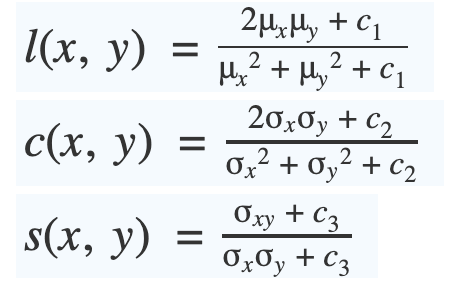

where μx, μy, σx, σy, and σxy are the local means, standard deviations, and cross-covariance for images x, y. c1, c2, c3 are constants.

SSIM can be then calculated as
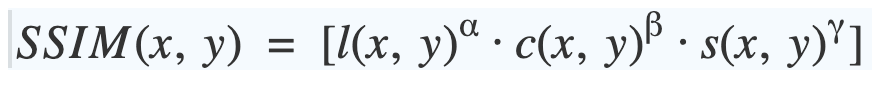

With ⍺, 𝛽, 𝛾 = 1 and C3 = C2 / 2, we can rewrite SSIM as follows:

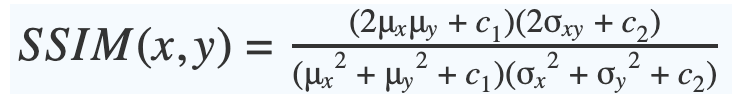

#### Why is SSIM a good loss function for the task?
SSIM has been shown to be a meaningful loss function for training Neural Networks, as it measures the cumulative distance between the output image and the target image [6]. Other losses, such as L1, merely calculate the element-wise distance between the pixels in the images, disregarding any spatial information or patterns in the pixels. 

The fastMRI challenge’s goal is to recreate clear and detailed MRI images from undersampled k-spaces. SSIM gives the network more information about the general structure of the target image, allowing it to better generalize a reconstruction procedure. Moreover, a relatively high loss compared to other loss functions, produces better results, as is detailed in the experiments section of this report. Moreover, SSIM was initially designed for single-channel images, similar to the ones used in the challenge.


## Implementation 

The following code cells outline the process of constructing and training the neural network, as well as data processing and evalutation. 

### Adaptations to the Baseline Model
The FastMRI Facebook challenge offers a baseline U-Net implementation. Experiments where conducted which focused on improving and extending the capabilities of this architecture. The first difference is the procedure for transferring features between the encoding and decoding layers. The skip-connections of the adapted model use concatenation to add high-resolution features from the downsampling layers to the spatial information of the upsamling layers . Secondly, batch normalisation is used between each convolutional block as opposed to instance normalisation in the baseline model. This normalises activations across a batch size rather than for each channel. This allows for faster training. Moreover, if variance in the batch is high, small activations would be completely suppressed in instance normalisation. Batch normalisation solves this issue by using the batch standard deviation to normalise. Lastly, the upsampling procedure of the modified network replaces interpolation with ConvTranspose. Transpose is a convolution which has trainable parameters whereas bilinear interpolation does not. This means that the network will be able to learn the upsampling method rather than rely on hardcoded methods. 



In [1]:
import torch 
import torch.nn as nn 

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
from torch.nn import functional as F
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from math import exp
import torch.optim as optim
from skimage.measure import compare_ssim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
torch.cuda.empty_cache()

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction)

### Get Epoch Batch 

This function is used by the PyTorch DataLoader to load the images. Given a subject, which is the result of the previous function, the k-space representation of the slice is extracted and used to create an undersampled version of it.
The implementation randomly selects which acceleration and center fraction to use for the mask involved in the process. The values used are 4 and 8 for acceleration and 0.08 and 0.04 for center fraction.

Finally, the real images are computed from the k-spaces and cropped to 320x320, to allow batching.


In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=False):

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=center_fract, accelerations=acc)
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und = img_gt/norm, img_und/norm
        
    img_gt, img_und = img_gt.squeeze(0), img_und.squeeze(0)
    
    img_gt, img_und = T.complex_abs(img_gt), T.complex_abs(img_und)
    
    return T.center_crop(img_gt, (320, 320)), T.center_crop(img_und, (320, 320))

### Load Data 

This function lists all the file names, file paths and slices for the training and validation sets. The sets are extracted from the same folder with a 60 - 10 split, for training and validation, respectively. This has proven to be a good split for accurate testing the generalization of the model.
For the training set, only the the 10 central slices are chosen, as they are the ones that contain most of the information needed for the reconstruction. External slices in the volume tend to contain darker or blurrier images, which has detrimental consequences on the model's performance. Moreover, less slices allow a faster training loop. The choice of the number of slices is a point of discussion in the experiment section.


In [6]:
def load_data_path(data_path):

    data_list = {}
    train_and_val = ['train', 'val']
    limit = 60
    
        
    files = sorted(os.listdir(data_path))
    
    for i in range(len(train_and_val)):

        data_list[train_and_val[i]] = []
        
        if i == 0 : selected_files = files[:limit]
        else : selected_files = files[limit:]
    
        for fname in selected_files:
                
            subject_data_path = os.path.join(data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            if i == 1:
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(0, num_slice)]
            else:
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(14, 25)]
    
    return data_list  

### Prepare the Data 

In [7]:
 
data_list = load_data_path('/data/local/NC2019MRI/train')

acc = [4,8]
cen_fract = [0.08, 0.04]
num_workers = 10 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
# create data loader for training set. It applies same to validation set as well
train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=5, num_workers=num_workers)

### Constructing the Network 

The U-Net consists of an encoder and a decoder. 

These are combinations of convolutional blocks, comprised of 3x3 Convolution layers, Batch Normalisation and ReLu activation. 

In [8]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, in_chans, out_chans):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, padding_mode='zeros', bias=False),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, input):
        
        return self.layers(input)


Upon construction of the network, it is possible to specify the depth of the network and how many convolutional blocks will be in each layer. Using a for loop and a ModuleList, a symmetric U-Net is constructed. 

After each convolutional block in the encoding (contracting) part of the network, there is a max pooling layer. This is a discretisation process which downsamples the image, allowing assumptions to be made about features of the image. A kernel size of 2 is used with a stride of 2. 

The original images, inputted to the network, have 1 channel. This is increased to 32 by the first convolutional layer. After each subsequent layer of the encoding part, the network's channels are doubled. 

The decoding part of the the network uses a transposed convolution to upsample the image. This allows the network to learn how to upsample optimally. 

As the network is symmetric, features can be transferred from the downsampling layers to the upsampling layers. This is done using by saving the output of specific downsampling layers and using concatenation to add them to their upsampling counterpart. 

In [9]:
class UNet(nn.Module):

    def __init__(self, input_chans, output_chans, chans, depth=3, level_len=1):

        super().__init__()
        

        self.chans = chans
        self.depth = depth
        self.level_len = level_len
        self.encoding_layers = nn.ModuleList()
        
        out_chans = chans
        
        # First level
        self.encoding_layers.append(ConvolutionalBlock(input_chans, chans))
        
        for j in range(level_len):
            self.encoding_layers.append(ConvolutionalBlock(chans, chans))
            
        self.encoding_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        '''ENCODER'''
        for i in range(depth-2):
            in_chans = out_chans
            out_chans = int(out_chans * 2)
            self.encoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
            
            for j in range(level_len):
                self.encoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
                
            self.encoding_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
                               
        in_chans = out_chans
        out_chans = int(out_chans * 2)
        self.encoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
        
        for j in range(level_len):
            self.encoding_layers.append(ConvolutionalBlock(out_chans, out_chans))       
        
        
        
        '''DECODER'''
        self.decoding_layers = nn.ModuleList()
                    
                                    
        in_chans = out_chans
        out_chans = int(in_chans / 2)
                                    
        self.decoding_layers.append(nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2)) 
                                    
        for i in range(depth-2):
            
            self.decoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
            
            for j in range(level_len):
                self.decoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
                
            in_chans = out_chans
            out_chans = int(out_chans / 2)
            self.decoding_layers.append(nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2))
                                    
        self.decoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
        
        for j in range(level_len): 
            self.decoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
        
        '''FINAL CONVOLUTION'''
        
        self.finalConv = nn.Conv2d(in_channels=out_chans, out_channels=output_chans, kernel_size=1)
     
        
    def forward(self, input):

        level_output = []
        index_to_save = 1
                                    
        '''ENCODE'''  
        for i, layer in enumerate(self.encoding_layers):
            input = layer(input)
            if i == index_to_save: 
                level_output.append(input)
                index_to_save += 2 + self.level_len             
                                    
                                    

        '''DECODE'''
        index_to_cat = 0
        for i, layer in enumerate(self.decoding_layers):
            input = layer(input)
            if i == index_to_cat:
                level_output.pop()
                index_to_cat += 2 + self.level_len  
                input =  torch.cat((input, level_output[-1]), dim=1)

        
        output = self.finalConv(input)

        return output 

### Final Network Implementation 

The optimal model was found though experimentation which will be futher detailed in this report.

It was found that the model which produces the best reconstructions whilst balancing the tradeoffs between GPU capabilities and training speed was: 
<ol>
    <li>A U-Net with 3 layers, each consisting of 4 Convolutional blocks.</li>
    <li>Using SSIM loss as the loss function</li>
    <li>Optimised using ADAM</li> 
    <li>Learning rate of 1e-4</li>
</ol>

In [10]:
#create a model
model = UNet(
    input_chans=1,
    output_chans=1,
    chans=32,
    depth=3,
    level_len=4
).to(device)

lr = 1e-4
optimiser = optim.Adam(model.parameters(), lr=lr)

### SSIM Implementation

The SSIM implementation is an adaptation of Pessoa [7]. A series of convolutional layers are used to extract the means, standard deviations and covariances of the images. These are then used to compute the similarity score as by equation above. The maximum value of the target image is used as a max range value, in order to increase the expressivity of the measurements and better describe the difference in quality between the two inputs. 



In [11]:
#ssim loss
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    L = img1.max()

    padd = 0
    (_, channel, height, width) = img1.size()

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    return ssim_map.mean()



# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11):
        super(SSIM, self).__init__()
        self.window_size = window_size

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, output_img, target_img):
        (_, channel, _, _) = output_img.size()
        
        if channel == self.channel and self.window.type == output_img.type:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(output_img.device).type(output_img.dtype)
            self.window = window
            self.channel = channel

        return 1 - ssim(target_img, output_img, window=window, window_size=self.window_size)

In [12]:
ssim_loss = SSIM()

## Training Loop

The model was trained for 100 epochs, where the loss converged at around 0.37.

In [13]:


epochs = 100


for epoch in range(epochs):
    model.train() 
    mean = []
    for iter, data in enumerate(train_loader):
        target_img, input_img = data
        input_img = input_img.to(device).unsqueeze(1)
        target_img = target_img.to(device).unsqueeze(1)

        output_img = model(input_img)
        
        loss = ssim_loss(output_img, target_img)
        # loss = msssim_loss(output, target)
        # loss = F.l1_loss(output, target)
        mean.append(loss)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    l = sum(mean)/len(mean)
    print("Epoch {}'s loss: {}".format(epoch, l))

Epoch 0's loss: 0.5120792388916016
Epoch 1's loss: 0.4256082773208618
Epoch 2's loss: 0.41019609570503235
Epoch 3's loss: 0.40937304496765137
Epoch 4's loss: 0.4040732979774475
Epoch 5's loss: 0.40065982937812805
Epoch 6's loss: 0.39522919058799744
Epoch 7's loss: 0.40095704793930054
Epoch 8's loss: 0.40253642201423645
Epoch 9's loss: 0.3977660536766052
Epoch 10's loss: 0.3989526629447937
Epoch 11's loss: 0.39253291487693787
Epoch 12's loss: 0.3872034549713135
Epoch 13's loss: 0.38755372166633606
Epoch 14's loss: 0.39267832040786743
Epoch 15's loss: 0.392144113779068
Epoch 16's loss: 0.3832555115222931
Epoch 17's loss: 0.3869946002960205
Epoch 18's loss: 0.38118064403533936
Epoch 19's loss: 0.385812371969223
Epoch 20's loss: 0.38573938608169556
Epoch 21's loss: 0.3823756277561188
Epoch 22's loss: 0.382865846157074
Epoch 23's loss: 0.3773401975631714
Epoch 24's loss: 0.3783779740333557
Epoch 25's loss: 0.38418665528297424
Epoch 26's loss: 0.378140926361084
Epoch 27's loss: 0.37734180688

In [14]:
PATH = 'model_final.h5'
torch.save(model.state_dict(), PATH)

In [15]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('model_final.h5'))
model.eval()

UNet(
  (encoding_layers): ModuleList(
    (0): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 

## Evaluation Loop 

Using SSIM, the accuracy of the reconstructions are evaluated. 
The mean accuracy is calculated accross all the images in the validation data (10/60 total images)

In [16]:
# create data loader for validation set
val_dataset = MRIDataset(data_list['val'], acceleration=acc, center_fraction=cen_fract)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=38, num_workers=num_workers)

In [17]:
def ssim_numpy(gt, pred):
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [18]:
ssim_scores = []

with torch.no_grad():
    for iteration, sample in enumerate(val_loader):
    
        img_gt, img_und = sample
    
        output_img = model(img_und.to(device).unsqueeze(1)).cpu().numpy().squeeze()
        ssim_scores.append(ssim_numpy(img_gt.squeeze(1).numpy(), output_img))
            
numpy_ssims = np.array(ssim_scores)
print("Mean:", numpy_ssims.mean())

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean: 0.7087113015276586


In [19]:
def save_reconstructions(reconstructions, out_dir, file_name):

    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, file_name)
        with h5py.File(subject_path, 'a') as f:
            f.create_dataset(fname, data=recons)

In [20]:
test_path = '/data/local/NC2019MRI/test/'
files = []
file_names = []

for r, d, f in os.walk(test_path):
    for file in f:
        files.append(os.path.join(r, file))
        file_names.append(file)

with torch.no_grad():
    for i in range(len(files)):
        with h5py.File(files[i],  "r") as hf:
            volume_kspace_4af = hf['kspace_4af'][()]
            volume_kspace_8af = hf['kspace_8af'][()]
            volume_kspace4 = T.to_tensor(volume_kspace_4af)
            volume_kspace8 = T.to_tensor(volume_kspace_8af) 
            _4af, _8af = T.ifft2(volume_kspace4), T.ifft2(volume_kspace8)
            norm_4af = T.complex_abs(_4af).max()
            if norm_4af < 1e-6: norm_4af = 1e-6
            norm_8af = T.complex_abs(_8af).max()
            if norm_8af < 1e-6: norm_8af = 1e-6
            _4af = _4af / norm_4af
            _8af = _8af / norm_8af
            _4af = T.complex_abs(_4af.squeeze(0))
            _4af = T.center_crop(_4af, (320, 320)).to(device)
            _8af = T.complex_abs(_8af.squeeze(0))
            _8af = T.center_crop(_8af, (320, 320)).to(device)

            recon_4af = model(_4af.unsqueeze(1)).squeeze(1).cpu()
            recon_8af = model(_8af.unsqueeze(1)).squeeze(1).cpu()

            reconstructions = {'recon_4af': recon_4af.numpy(), 'recon_8af': recon_8af.numpy()}
            out_dir = 'saved/'
            if not (os.path.exists(out_dir)): os.makedirs(out_dir)
            save_reconstructions(reconstructions, out_dir, file_names[i])
        

# Experimentation 

As an attempt to improve upon the accuracy of the baseline U-Net model, there are a number of parameters and implementation features that can be changed and evaluated. 

These include: 

<ol>
    <li>Using a different <b>loss function</b> when training the network. The loss function is a method of evaluating how well the learned feature mapping models the dataset.</li>
    <li>Using a different <b>optimiser</b>. The optimiser provides the methods used to change the attributes of the network (weights and learning rate) in order to reduce the loss.</li> 
    <li>Altering the <b>architecture</b> of the network. For example adding more layers to the U-Net to make it deeper or adding more convolutional layers to each convolutional block. </li>
</ol>

The methods of experimentation and experimentation results are outlined below: 

## Loss Function 

<b>Mean Squared Error (L2)</b>

The initial loss function used was Mean Square Error (L2). This is the sum of the squared distances between the target image (ground truth) and the output of the model (reconstruction).

<b>Mean Absolute Error (L1)</b>

Mean absolute error used the sum of the absolute differences between target and output. This measures the average magnitude of errors without considering directions, making it more robust to outliers

<b>SSIM Loss</b>

Finally, The Structural Similarity Index can be used as a metric to assess the degradation of images during data processing.
SSIM is used to evaluate the final accuracy of reconstructions, therefore, it is a sensible metric to use as a loss function for the network. 

<b>The results of the loss per epoch obtained by the U-Net comparing L1, L2 and SSIM loss</b>

<table>
    <tr>
        <th>Loss Function</th>
        <th>Loss After 10 Epochs</th>
        <th>Loss After 20 Epochs</th>
        <th>Mean SSIM Accuracy</th>
    </tr>
    <tr>
        <td>L1</td>
        <td>0.06574003398</td>
        <td>0.05880469829</td>
        <td>0.6248441702</td>
    </tr>
    <tr>
        <td>L2</td>
        <td>0.01459008269</td>
        <td>0.007406517398</td>
        <td>0.6135491548</td>
    </tr>
    <tr>
        <td>SSIM</td>
        <td>0.3496744633</td>
        <td>0.3511980176</td>
        <td>0.6521201111</td>
    </tr>

</table>


<b>MSSSIM Loss</b>

Multi-Scale Structural Similarity index (MS-SSIM) is an evolution of SSIM. As its predecessor, it measures the similarity between two images. Experiments showed that MS-SSIM focuses predominantly on dark regions, inevitably worsening the accuracy of the model.

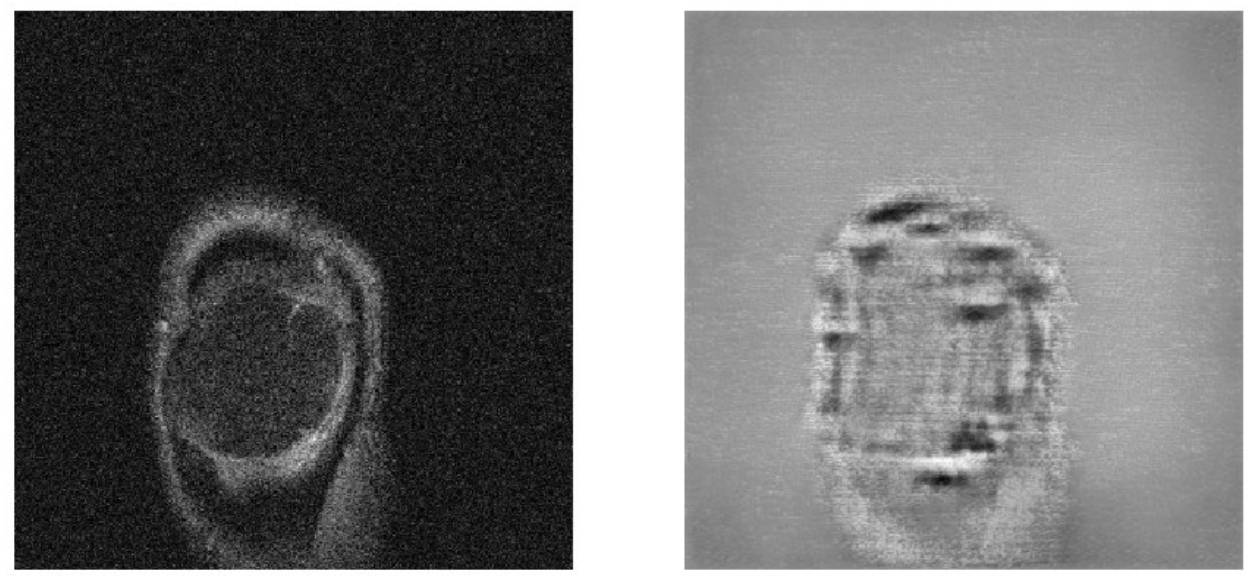

<b>MSSSIM + L1 Loss</b>

As suggested by Zbontar et al. [1], MS-SSIM issues can be overcome with the help of the L1 loss function, as the latter tends to keep the contrast in the image. However, in the proposed model, the result images were either blurried or excessively dark.

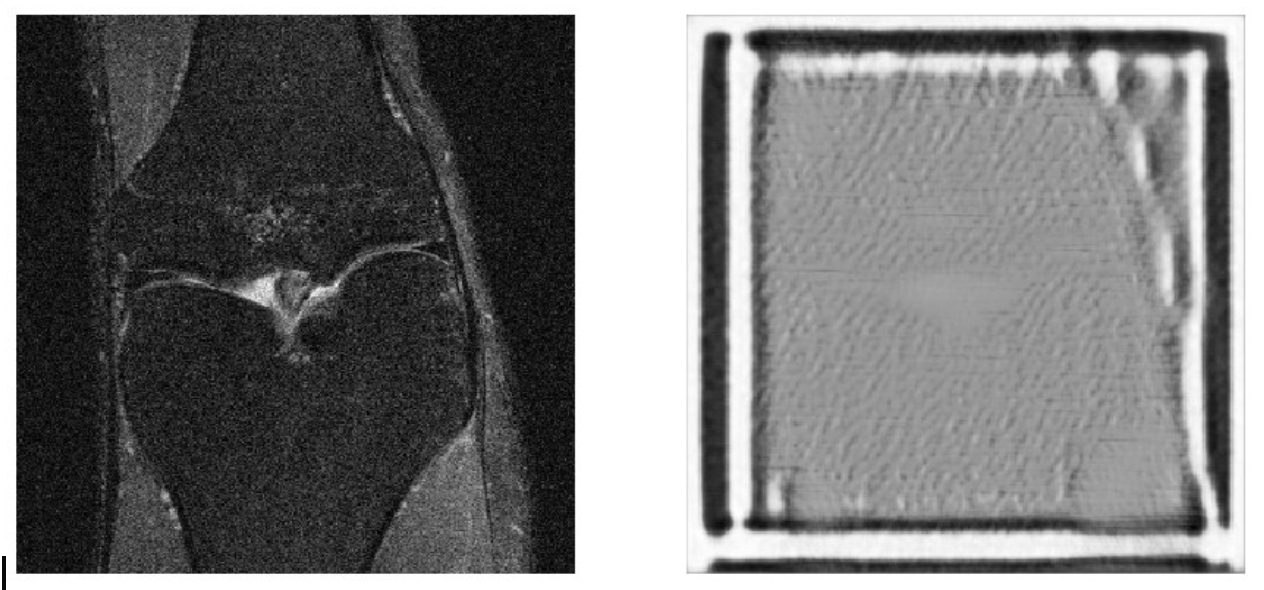

## Optimiser 

<b>Gradient Descent</b>
The most basic optimisation algorithm is gradient descent. It dependends on the first order derivative of a loss function to calculate the way in which weights should be altered to reach a minima. It is easy to compute, however, it is possible to get trapped in a local minima and it requires a large amount of memory. 

<b>ADAM</b>
Adaptime Moment Estimation uses momentums of first and second order. It provides a careful search for the minima and keeps track of past gradients. Although it is computationally costly, it converges rapidly and can cope with high variance in the data. 

<b>RMSProp</b>
Root Mean Square Propogation extends the idea of momentum: each parameter in the network has its own personal learning rate. RMSProp has been proven to be a very costly but successful optimization technique.

ADAM and RMSProp were compared. 

<b>The Results of Loss per Epoch due to Changing the Optimiser</b>

<table>
    <tr>
        <th>Optimiser</th>
        <th>Loss After 10 Epochs</th>
        <th>Loss After 20 Epochs</th>
        <th>Mean SSIM Accuracy</th>
    </tr>
    <tr>
        <td>RMSProp</td>
        <td>0.3708318174</td>
        <td>0.3543377817</td>
        <td>0.6107824831</td>
    </tr>
    <tr>
        <td>ADAM</td>
        <td>0.3496744633</td>
        <td>0.3511980176</td>
        <td>0.6521201111</td>
    </tr>
    

</table>

## Network Architecture

Experiments were conducted by changing the depth and length of the network. 

<b>Results of Altering the Depth of the Network</b>

<table>
    <tr>
        <th>Depth</th>
        <th>Loss After 10 Epochs</th>
        <th>Loss After 20 Epochs</th>
        <th>Loss After 30 Epochs</th>
        <th>Mean SSIM Accuracy</th>
    </tr>
    <tr>
        <td>3</td>
        <td>0.4109104574</td>
        <td>0.400467366</td>
        <td>0.3923389912</td>
        <td>0.6072865443</td>
    </tr>
    <tr>
        <td>5</td>
        <td>0.4246649742</td>
        <td>0.4056791067</td>
        <td>0.4098438621</td>
        <td>0.4098438621</td>
    </tr>
    <tr>
        <td>7</td>
        <td>0.4246649742</td>
        <td>0.4056791067</td>
        <td>0.3892657459</td>
        <td>0.6283836738</td>
    </tr>

</table>

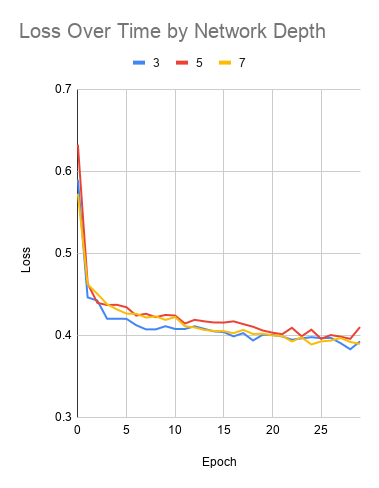

<table>
    <tr>
        <th>Length</th>
        <th>Loss After 10 Epochs</th>
        <th>Loss After 20 Epochs</th>
        <th>Loss After 30 Epochs</th>
        <th>Mean SSIM Accuracy</th>
    </tr>
    <tr>
        <td>1</td>
        <td>0.4121080637</td>
        <td>0.4078176916</td>
        <td>0.3911235631</td>
        <td>0.6216806885</td>
    </tr>
    <tr>
        <td>2</td>
        <td>0.4246649742</td>
        <td>0.4056791067</td>
        <td>0.4056791067</td>
        <td>0.6065510197</td>
    </tr>
    <tr>
        <td>3</td>
        <td>0.4118671715</td>
        <td>0.4107398987</td>
        <td>0.3944874108</td>
        <td>0.6124401789</td>
    </tr>
    <tr>
        <td>4</td>
        <td>0.4015573263</td>
        <td>0.4082061648</td>
        <td>0.3841308057</td>
        <td>0.6276819296</td>
    </tr>
    <tr>
        <td>5</td>
        <td>0.4063067436</td>
        <td>0.4063067436</td>
        <td>0.3823754787</td>
        <td>0.611702523</td>
    </tr>

</table>

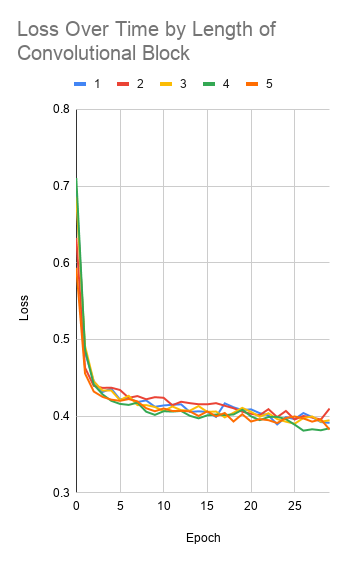

## Data Pre-Processing 

Altering the number of slices per image has an effect on the accuracy of the reconstructions.

It was found that the optimal number of slices to use was 10 because it balances the tradeoff between training time and the loss converges to that achieved using a larger number. 

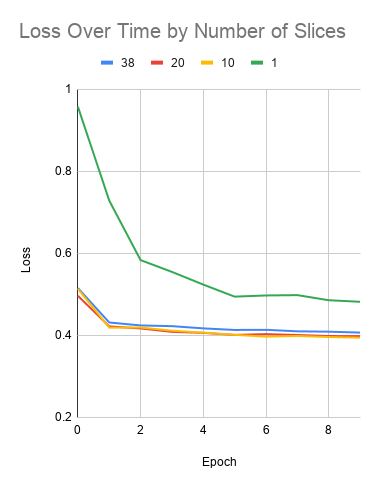


# Conclusion 

Overall, the network managed to achieve a reconstruction accuracy of 70%, using SSIM as an evaluation metric. 

The best network architecture was established: a U-Net using 3x3 convolutions, Max Pooling to downsample, Concatenation to transfer features between contracting and expanding paths, and Transpose Convolution to upsample. 

During experimentation, the most crucial factors where the loss function and the optimiser. It was found that using SSIM as a loss function impoved the accuacy by 3% and switching from RMSProp to ADAM improved the accuacy by 4%. 

Although increasing the depth of the network gave a slight impovement on the loss, the loss still converged at around 0.38. Therefore, it was beneficial to use a shallower network to decrease training time.  

## Limitations of the Solution
The nature of the project is highly experimental. There will always be further experiments to conduct, different parameters to change, different loss functions to explore. It is highly likely that the final solution is not the optimal one. More time to experiment would likely lead to better results.  

Moreover, the training of the network is limited by the capabilities of the GPU of the machines on which the model is trained on. Potentially, a lower loss could have been achieved had the model been trained for more epochs. 

## Futher Experiments 

To further improve the results of the solution, different adapatations of the U-Net could be implemented and analysed. For example, a <b>Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)</b>

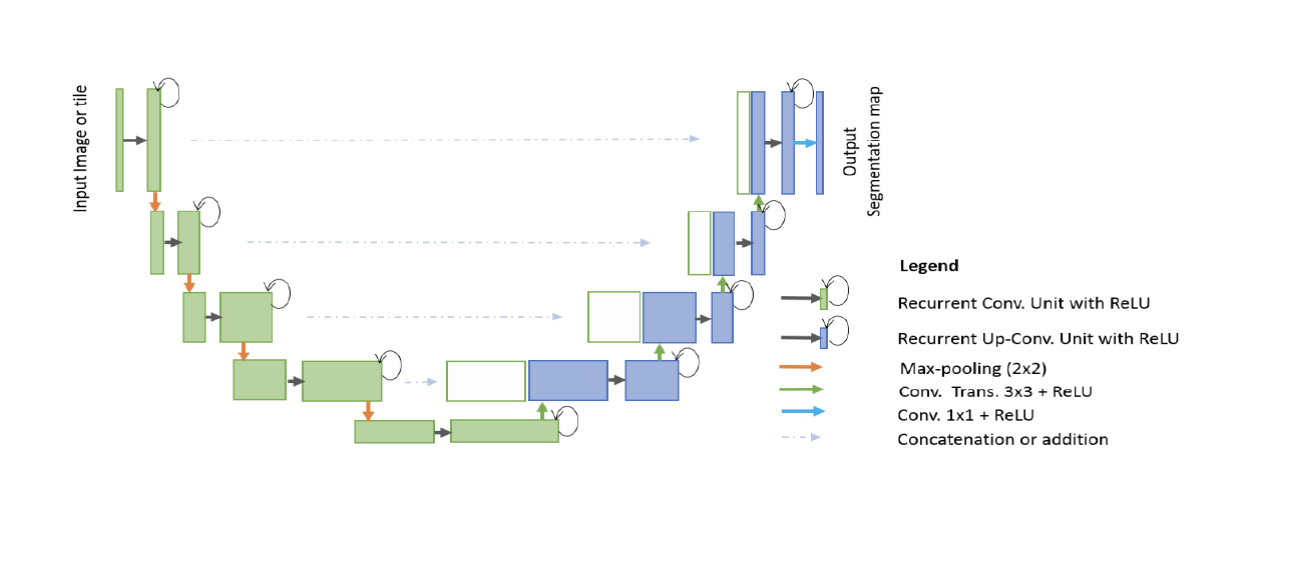 


The motivation for using this model comes from its consistent performance improvements over a regular U-Net model [8] for image segmentation tasks. 

The R2U-Net is based on the U-Net model with two additional modifications to the convolutional blocks. The first of which comes from a Recurrent Convolutional Neural Networks, while the second modification comes from Residual Convolutional Neural Networks.  

The Recurrent Convolutional Layer block is based on Recurrent Convolutional Neural Networks. The idea of this approach comes from the way a biological brain uses recurrent synapses for context modulation [9]. The context is important because the same object could be recognised in multiple ways depending on the environment surrounding it. One way to improve context modulation in Convolutional Neural Networks is to use recurrent connections within the same layer of a deep learning model as demonstrated in Figure 1.

<table>
<tr>
<td> <img src="https://i.ibb.co/rfvc1hR/fig1.png" alt="Drawing" style="width:300px;"/> </td>
<td> <img src="https://i.ibb.co/J5r8zTk/fig2.png" alt="Drawing" style="width:300px;"/> </td>
<td> <img src="https://i.ibb.co/2y5dTDR/fig3.png" alt="Drawing" style="width:300px;"/> </td>
</tr>
    
    
<tr>
<td> <center> Figure 1 </center> </td>  
    <td> <center> Figure 2 </center> </td>  
    <td> <center> Figure 3 </center> </td>  
</tr>    
</table>

The other important modification is based on Residual Neural Networks (ResNets). As the number of layers grows (which is especially relevant when using recurrent Convolutional blocks), the problem is that degradation starts to emerge. As the network depth increases, accuracy gets saturated and degrades rapidly. One solution to this issue is to use Residual Convolutional blocks (Figure 2) as described by Kaiming, et al [10]. This approach uses “shortcut connections” (connections that skip one or more layers) to add identity mapping in a way that does not add any addition hyperparameters or complexity and is proven to help with degradation on large networks.


Figure 3 shows the combined Recurrent Residual Convolutional block that was used during testing. The hypothesis was that the recurrency would help with reconstructing the more intricate parts of the image while residual “shortcuts” would minimize the degradation. 


Another possible architecture is an <b>Attention U-Net</b>

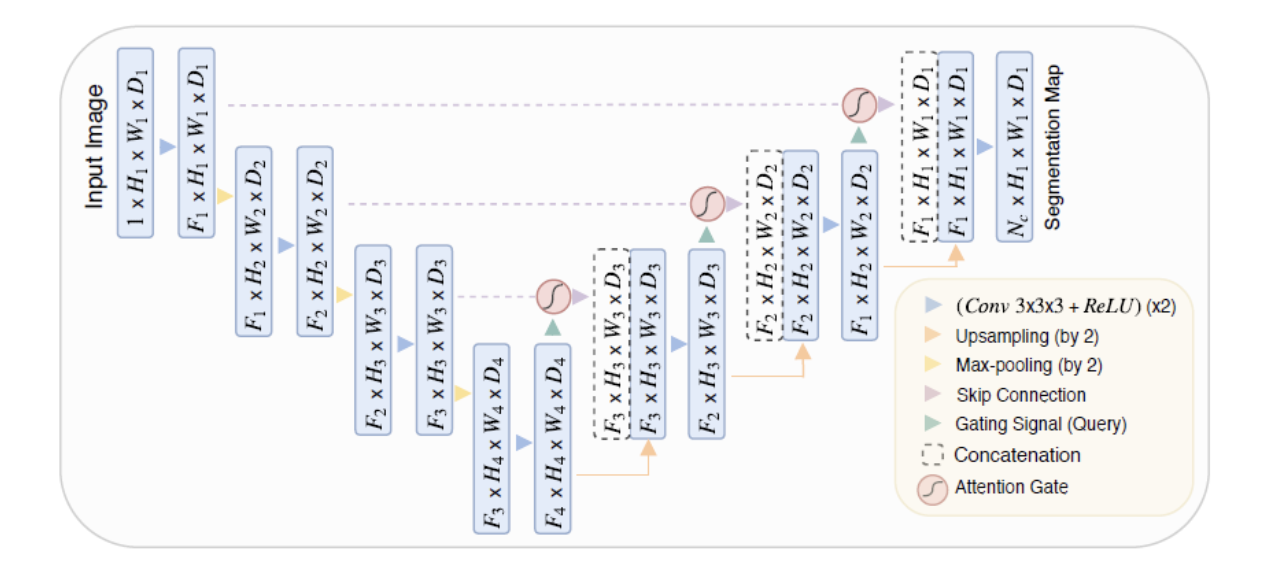

By analyzing the k-space slices it was discovered that majority of slices have very little information - in many slices the region of interest for the reconstruction takes up less than 30% of the image.

Attention U-Net is a modification of a standard U-Net that uses Attention Gates to focus on target features instead of the entire image, without additional supervision [11]. This allows for fewer redundant parameters and unnecessary computations when compared with other methods.



## Reconstructions 

Below you can see a sample of the MRI reconstructions that the model achieves, compared with the ground truth. 

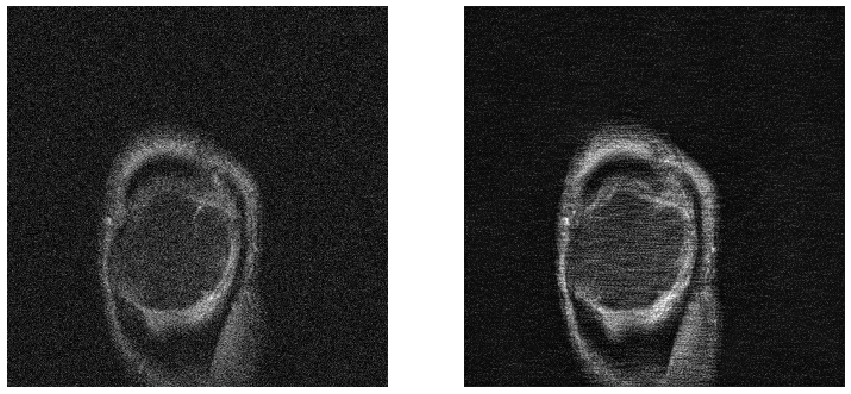

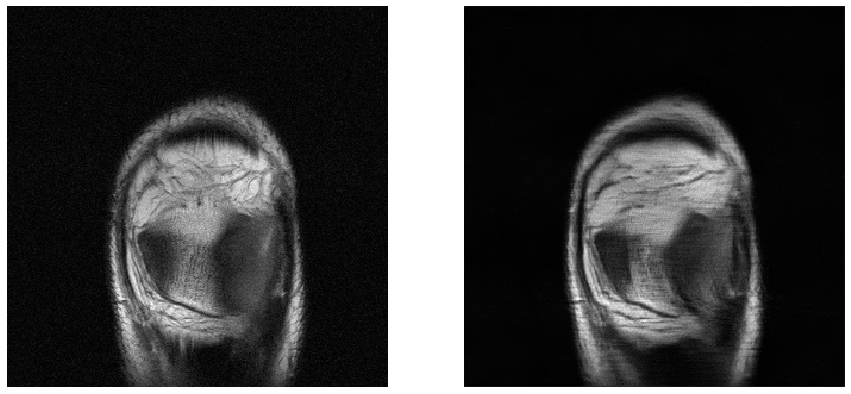

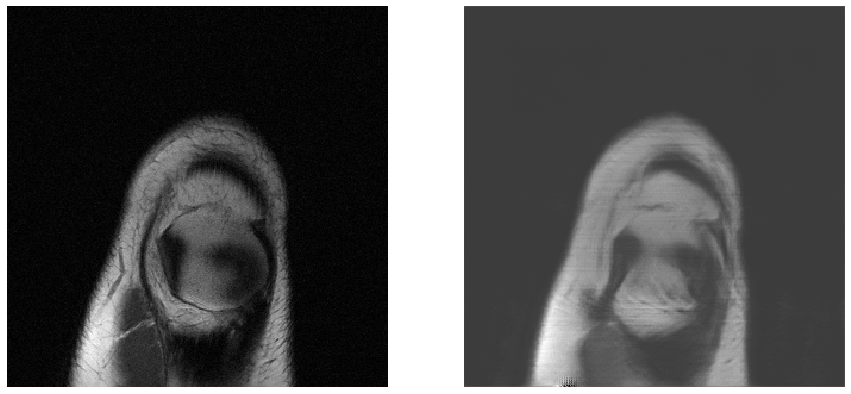

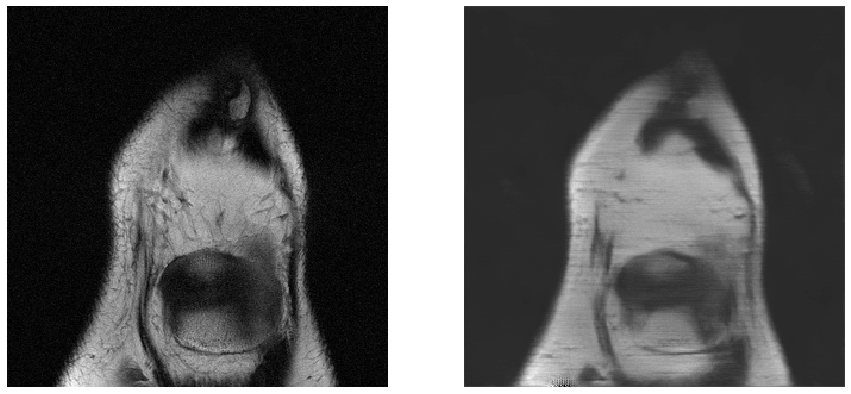

In [21]:
with torch.no_grad():
    for iteration, sample in enumerate(val_loader):
    
        img_gt, img_und = sample
    
        output_img = model(img_und.to(device).unsqueeze(1)).cpu().numpy().squeeze()
        show_slices([img_gt.squeeze(1).numpy()[6], output_img[6]], [0, 1], cmap='gray')
        
        if iteration >= 3: break

Overall, the solution is able to acheive moderate to high reconstruction accuracy using undersampled K-Space data. It can be considered useful for the task of impoving patient comfort by speeding up MRI scans. 

## Team Contribution

<table>
  <tr>
    <th>NAME</th>
    <th>MAIN TASK</th>
    <th>PERCENTAGE</th>
  </tr>
  <tr>
    <td>Vycas Tomas</td>
    <td>Architecture experiments</td>
    <td>28%</td>
  </tr>
  <tr>
    <td>Fiorindo Giacomo</td>
    <td>Loss functions and optimizer experiments</td>
    <td>28%</td>
  </tr>
    <tr>
    <td>Corney Alexis</td>
    <td>UNet implementation, experiments and expansion</td>
    <td>28%</td>
  </tr>
  <tr>
    <td>Logofatu Emil Gabriel</td>
    <td>N/A</td>
    <td>0%</td>
  </tr>
  
  <tr>
    <td>Xu Yue</td>
    <td>Research</td>
    <td>16%</td>
  </tr>

</table>

# References 

[1] Zbontar, Jure, Florian Knoll, Anuroop Sriram, Matthew J. Muckley, Mary Bruno, Aaron Defazio, Marc Parente, et al. ‘FastMRI: An Open Dataset and Benchmarks for Accelerated MRI’. ArXiv:1811.08839 [Physics, Stat], 21 November 2018. http://arxiv.org/abs/1811.08839.


[2] Sun, Liyan, Zhiwen Fan, Xinghao Ding, Yue Huang, and John Paisley. ‘Joint CS-MRI Reconstruction and Segmentation with a Unified Deep Network’. In Information Processing in Medical Imaging, edited by Albert C. S. Chung, James C. Gee, Paul A. Yushkevich, and Siqi Bao, 11492:492–504. Cham: Springer International Publishing, 2019. https://doi.org/10.1007/978-3-030-20351-1_38.

[3] Sankesara, Heet. ‘U-Net’. Medium, 23 January 2019. https://towardsdatascience.com/u-net-b229b32b4a71.

[4]	Z. Wang, A. C. Bovik, H. R. Sheikh, E. P. Simoncelli, "Image quality assessment: From error measurement to structural similarity", IEEE Trans. Image Processing, vol. 13, Jan. 2004.

[5]	Wang, Zhou, Eero P. Simoncelli, and Alan C. Bovik. "Multiscale structural similarity for image quality assessment." The Thrity-Seventh Asilomar Conference on Signals, Systems & Computers, 2003. Vol. 2. Ieee, 2003.

[6]	Zhao, Hang, et al. "Loss functions for image restoration with neural networks." IEEE Transactions on Computational Imaging 3.1 (2016): 47-57.

[7] 	Pessoa, “pytorch-msssim”. https://github.com/jorge-pessoa/pytorch-msssim

[8] Alom, Md Zahangir, Mahmudul Hasan, Chris Yakopcic, Tarek M. Taha, and Vijayan K. Asari. ‘Recurrent Residual Convolutional Neural Network Based on U-Net (R2U-Net) for Medical Image Segmentation’. ArXiv:1802.06955 [Cs], 29 May 2018. http://arxiv.org/abs/1802.06955.

[9] A. Sharif Razavian, H. Azizpour, J. Sullivan, and S. Carls-son. Cnn features off-the-shelf: An astounding baseline for
recognition. In The IEEE Conference on Computer Vision
and Pattern Recognition (CVPR) Workshops, 2014.

[10]	He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[11]	Oktay, Ozan, et al. "Attention u-net: Learning where to look for the pancreas." arXiv preprint arXiv:1804.03999 (2018).

[12] ‘How Much Does An MRI Cost | GE Healthcare’. Accessed 12 December 2019. https://www.gehealthcare.co.uk/feature-article/how-much-does-an-mri-cost.

